In [26]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import sklearn.model_selection as model_selection
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.utils import shuffle

In [10]:
os.chdir('../10_Data/20_Extracted Tweets/10_2018 Train')

In [11]:
os.getcwd()

'C:\\Users\\Vishaal\\Documents\\GitHub\\TREC_Distributed_Machine_Learning\\TREC\\10_Data\\20_Extracted Tweets\\10_2018 Train'

In [12]:
'''
    Loading Earthquake and flood data from 2018 train. These are the only ones with critical tweets
'''
df1 = pd.read_csv('flood_TREC_2018_train.csv')
df2 = pd.read_csv('Earthquake_TREC_2018_train.csv')

In [13]:
os.chdir('../15_2018 Test')

In [14]:
'''
    Loading our test 2018 tweets from eathquakes and floods. These have a decent amount of critical tweets.
    We did not include attacks as a considerable amount of work has been done on that before.
'''
df3 = pd.read_csv('Earthquake_TREC_2018_test.csv')
df4 = pd.read_csv('Floods_TREC_2018_test.csv')

In [15]:
'''
    Combining all into one big data frame
'''
df_c = pd.DataFrame()
df_c['Tweet'] = pd.concat([df1['Tweet'] , df2['Tweet'], df3['Tweet'], df4['Tweet'] ])
df_c['Priority'] = pd.concat([df1['Priority'] , df2['Priority'], df3['Priority'], df4['Priority']])



In [16]:
'''
    52 Critical tweets out of 7432
'''
(df_c[df_c['Priority']=='Critical']).shape

(55, 2)

In [17]:
'''
Creating a categorical variable to keep label critical tweets as 1 and 0 otherwise
'''
def to_categorical(df_c):
    t = []
    for element in df_c['Priority']:
        if element =='Critical':
            t.append(1)
        else:
            t.append(0)
        
    t = np.array(t)
    df_c['Target'] = t

    df_c['Target'] = df_c['Target'].astype('category')
    t = df_c['Target']
    del df_c['Target']
    return (t)

t = to_categorical(df_c)

In [18]:
'''
    Creating a function to input lemmatized text to possibly another function that outputs the tfidf in a csv format.
    We could also simply use the output from this funtion in an tfidf format (no csv) and train a model.
'''
def preProcess(df):
    df['Tweet'] = df['Tweet'].astype('str')
    
    token_array = []
    for tweet in df['Tweet']:
        token_tweet = word_tokenize(tweet)
        token_array.append(token_tweet)
        
    stop_words=set(stopwords.words("english"))
    filtered_token_array=[]
    for tweet in token_array:
        filtered_tweet = []
        for word in tweet:
                if word not in stop_words:
                    filtered_tweet.append(word)
        filtered_token_array.append(filtered_tweet)
        
    lem = WordNetLemmatizer()
    stem = PorterStemmer()

    lemmatized_array=[]
    for tweet in filtered_token_array:
        lemmatized_tweet = []
        for word in tweet:
            lemmatized_tweet.append(lem.lemmatize(word,'v'))
        lemmatized_array.append(lemmatized_tweet)
    
    lemmatized_array_join = []
    for element in lemmatized_array:
        lemmatized_array_join.append(''.join(element))
        
    return (lemmatized_array_join)

In [19]:
'''
    OPTIONAL - We use this to convert the tfidf into CSV format. 
    
    Output is a combined dataframe - use pd.to_csv to specify save location 
    
    NOTE - corpus is tfidf in non-array format
'''
def tfidf_to_CSV(df, corpus):
    tf=TfidfVectorizer()
    text_tf= tf.fit_transform(corpus)
    text_tf_dense = text_tf.todense()
    
    words = tf.get_feature_names()
    M = text_tf.tolil()
    l_features = []
    for i in range(M.shape[0]):
        l_features.append(np.array(M[i].todense())[0])
        
    df_features = pd.DataFrame(l_features)
    
    df_combined = pd.concat([df,df_features], axis=1)
    
    cols = list(df.columns) + words
    
    df_combined_1 = df_combined.rename(columns={x:y for x,y in zip(df_combined.columns,cols)})
    
    return (df_combined_1)

In [20]:
'''
    Plot no skill and ROC curve
'''
def plot_roc_curve(test_y, naive_probs, model_probs):
	# plot naive skill roc curve
	fpr, tpr, _ = roc_curve(test_y, naive_probs)
	plt.plot(fpr, tpr, linestyle='--', label='No Skill')
	# plot model roc curve
	fpr, tpr, _ = roc_curve(test_y, model_probs)
	plt.plot(fpr, tpr, marker='.', label='SVM SGD')
	# axis labels
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	# show the legend
	plt.legend()
	# show the plot
	plt.show()

In [21]:
'''
    Plot no skill model and PR curve
'''
def plot_pr_curve(test_y, model_probs):
	# calculate the no skill line as the proportion of the positive class
	no_skill = len(test_y[test_y==1]) / len(test_y)
	# plot the no skill precision-recall curve
	plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
	# plot model precision-recall curve
	precision, recall, _ = precision_recall_curve(test_y, model_probs)
	plt.plot(recall, precision, marker='.', label='SVM SGD')
	# axis labels
	plt.xlabel('Recall')
	plt.ylabel('Precision')
	# show the legend
	plt.legend()
	# show the plot
	plt.show()


In [22]:
'''
    Converting TF-IDF to list of lists. Then we play around with the datatypes to get features as a dense
    list of numpy arrays l_features. We also get the actual word names that are used as features.
    
    Use only if you need the csv output. NOT REQUIRED TO TRAIN MODEL
'''
words = tf.get_feature_names()
M = text_tf.tolil()
l_features = []
for i in range(M.shape[0]):
    l_features.append(np.array(M[i].todense())[0])

NameError: name 'tf' is not defined

In [46]:
'''
    Let us now balance the dataset and see what happens. We have 52 critical tweets so lets balance that with
    200 low priority tweets.
'''
df_low = df_c[df_c['Priority'] == 'Low'].sample(200)
df_crit = df_c[df_c['Priority'] == 'Critical']
df_lc = pd.concat([df_low, df_crit])
df_lc = shuffle(df_lc)

In [47]:
'''
    Convert to categorical
'''
t_lc = to_categorical(df_lc)
'''
    Getting a DTM of tf-idf features
'''
tf=TfidfVectorizer()
lemmatized_array_join = preProcess(df_lc)
text_lc= tf.fit_transform(lemmatized_array_join)
'''
    Converting DTM to array. REQUIRED TO DIRECTLY TRAIN SVM
'''
text_lc= tf.fit_transform(lemmatized_array_join).toarray()

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Recall Score =  0.25
Precision Score 0.75
[[38  1]
 [ 9  3]]
ROC AUC 0.710
PR AUC: 0.650


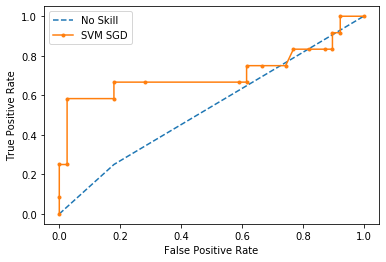

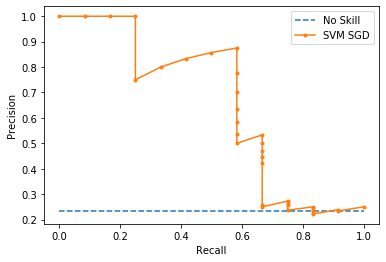

In [52]:
'''
    SGD SVM on Critical-Low Dataset.
'''
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(text_lc, t_lc, test_size=0.2, random_state=100)
'''
    Create a Dummy Classifier
'''
naive_model = DummyClassifier(strategy='stratified')
naive_model.fit(X_train, Y_train)
yhat = naive_model.predict_proba(X_val)
naive_probs = yhat[:, 1]

'''
    Actual SVM using SGD
'''
clf = SGDClassifier(loss = 'hinge', alpha = 0.001, max_iter=10000, tol=1e-3
                                                   , shuffle = True, learning_rate = 'optimal', penalty='l1')
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_val)
'''
    Calibrating above model to yield probabilities. SGD with hinge loss does not spit out prob. It gives the value of 
    the decision function aka the value of the function across th hyperplane but that does not help us in this case. 
    Using loss as log or something else will give prob but we want to do SVM and not logistic regression. Finally, 
    other 
'''
model = CalibratedClassifierCV(clf)
model.fit(X_train, Y_train)
proba_cl = model.predict_proba(X_val)[:, 1]
'''
    Get recall and precisions scores
'''
print('Recall Score = ', metrics.recall_score(Y_val, y_pred))
print('Precision Score', metrics.precision_score(Y_val, y_pred))
print(metrics.confusion_matrix(Y_val, y_pred))

'''
    Plot ROC curve
'''
plot_roc_curve(Y_val, naive_probs, proba_cl)
roc_auc = roc_auc_score(Y_val, proba_cl)
print('ROC AUC %.3f' % roc_auc)
'''
    Plot PR curve
'''
precision, recall, _ = precision_recall_curve(Y_val, proba_cl)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)
plot_pr_curve(Y_val, proba_cl)





In [297]:
len(y_pred)

51